In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image as keras_image  # Import the image module
from tensorflow.keras.utils import to_categorical
import cv2

In [2]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 91% 135M/149M [00:01<00:00, 127MB/s]
100% 149M/149M [00:01<00:00, 140MB/s]


In [3]:
def get_class_paths(path):
  classes=[]
  class_paths=[]
  #Iterate through directories in the training path
  for label in os.listdir(path):
    label_path=os.path.join(path,label)

    #Check if directory
    if os.path.isdir(label_path):
      #Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path=os.path.join(label_path,image)

        #Add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  df = pd.DataFrame({'Class Path': class_paths,'Class': classes})
  return df

In [ ]:
!mkdir -p Masks/glioma Masks/meningioma Masks/pituitary Masks/"notumor"

In [4]:
tr_df = get_class_paths("/content/Training")

In [5]:
tr_df

Class Path       Class
0     /content/Training/meningioma/Tr-me_0713.jpg  meningioma
1     /content/Training/meningioma/Tr-me_0284.jpg  meningioma
2     /content/Training/meningioma/Tr-me_0434.jpg  meningioma
3     /content/Training/meningioma/Tr-me_1236.jpg  meningioma
4     /content/Training/meningioma/Tr-me_1113.jpg  meningioma
...                                           ...         ...
5707   /content/Training/pituitary/Tr-pi_0928.jpg   pituitary
5708   /content/Training/pituitary/Tr-pi_0513.jpg   pituitary
5709   /content/Training/pituitary/Tr-pi_1178.jpg   pituitary
5710   /content/Training/pituitary/Tr-pi_0627.jpg   pituitary
5711   /content/Training/pituitary/Tr-pi_0768.jpg   pituitary

[5712 rows x 2 columns]

In [6]:
ts_df = get_class_paths("/content/Testing")

In [7]:
ts_df

Class Path       Class
0     /content/Testing/meningioma/Te-me_0064.jpg  meningioma
1     /content/Testing/meningioma/Te-me_0303.jpg  meningioma
2     /content/Testing/meningioma/Te-me_0172.jpg  meningioma
3     /content/Testing/meningioma/Te-me_0092.jpg  meningioma
4     /content/Testing/meningioma/Te-me_0096.jpg  meningioma
...                                          ...         ...
1306   /content/Testing/pituitary/Te-pi_0123.jpg   pituitary
1307   /content/Testing/pituitary/Te-pi_0077.jpg   pituitary
1308   /content/Testing/pituitary/Te-pi_0203.jpg   pituitary
1309   /content/Testing/pituitary/Te-pi_0275.jpg   pituitary
1310   /content/Testing/pituitary/Te-pi_0169.jpg   pituitary

[1311 rows x 2 columns]

<Axes: xlabel='Class', ylabel='count'>

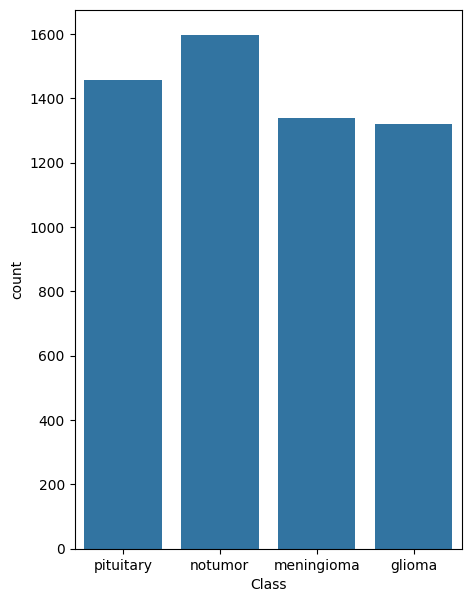

In [ ]:
plt.figure(figsize=(5,7))
ax = sns.countplot(data=tr_df, x=tr_df['Class'])
ax

<Axes: xlabel='Class', ylabel='count'>

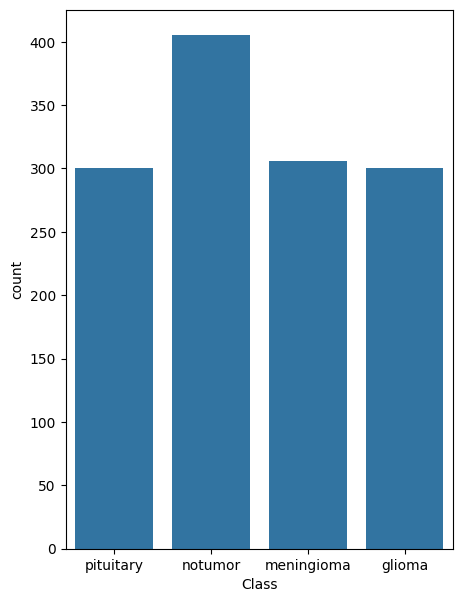

In [ ]:
plt.figure(figsize=(5,7))
ax = sns.countplot(data=ts_df, x=ts_df['Class'])
ax

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
valid_df, ts_df = train_test_split(ts_df, test_size=0.5, random_state=42, stratify=ts_df['Class'])

In [10]:
valid_df

Class Path       Class
843     /content/Testing/notumor/Te-no_0309.jpg     notumor
29   /content/Testing/meningioma/Te-me_0104.jpg  meningioma
776     /content/Testing/notumor/Te-no_0150.jpg     notumor
464      /content/Testing/glioma/Te-gl_0140.jpg      glioma
291  /content/Testing/meningioma/Te-me_0266.jpg  meningioma
..                                          ...         ...
177  /content/Testing/meningioma/Te-me_0047.jpg  meningioma
433      /content/Testing/glioma/Te-gl_0075.jpg      glioma
415      /content/Testing/glioma/Te-gl_0124.jpg      glioma
764     /content/Testing/notumor/Te-no_0271.jpg     notumor
170  /content/Testing/meningioma/Te-me_0060.jpg  meningioma

[655 rows x 2 columns]

In [11]:
ts_df

Class Path       Class
102   /content/Testing/meningioma/Te-me_0247.jpg  meningioma
50    /content/Testing/meningioma/Te-me_0211.jpg  meningioma
966      /content/Testing/notumor/Te-no_0267.jpg     notumor
185   /content/Testing/meningioma/Te-me_0034.jpg  meningioma
346       /content/Testing/glioma/Te-gl_0285.jpg      glioma
...                                          ...         ...
678      /content/Testing/notumor/Te-no_0343.jpg     notumor
1133   /content/Testing/pituitary/Te-pi_0114.jpg   pituitary
717      /content/Testing/notumor/Te-no_0119.jpg     notumor
220   /content/Testing/meningioma/Te-me_0083.jpg  meningioma
34    /content/Testing/meningioma/Te-me_0289.jpg  meningioma

[656 rows x 2 columns]

In [ ]:
batch_size = 32 # 2^5+  are all valid batch sizes
img_size = (299, 299)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range = (0.8,1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
tr_gen = image_generator.flow_from_dataframe(
    dataframe=tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(
    dataframe=ts_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


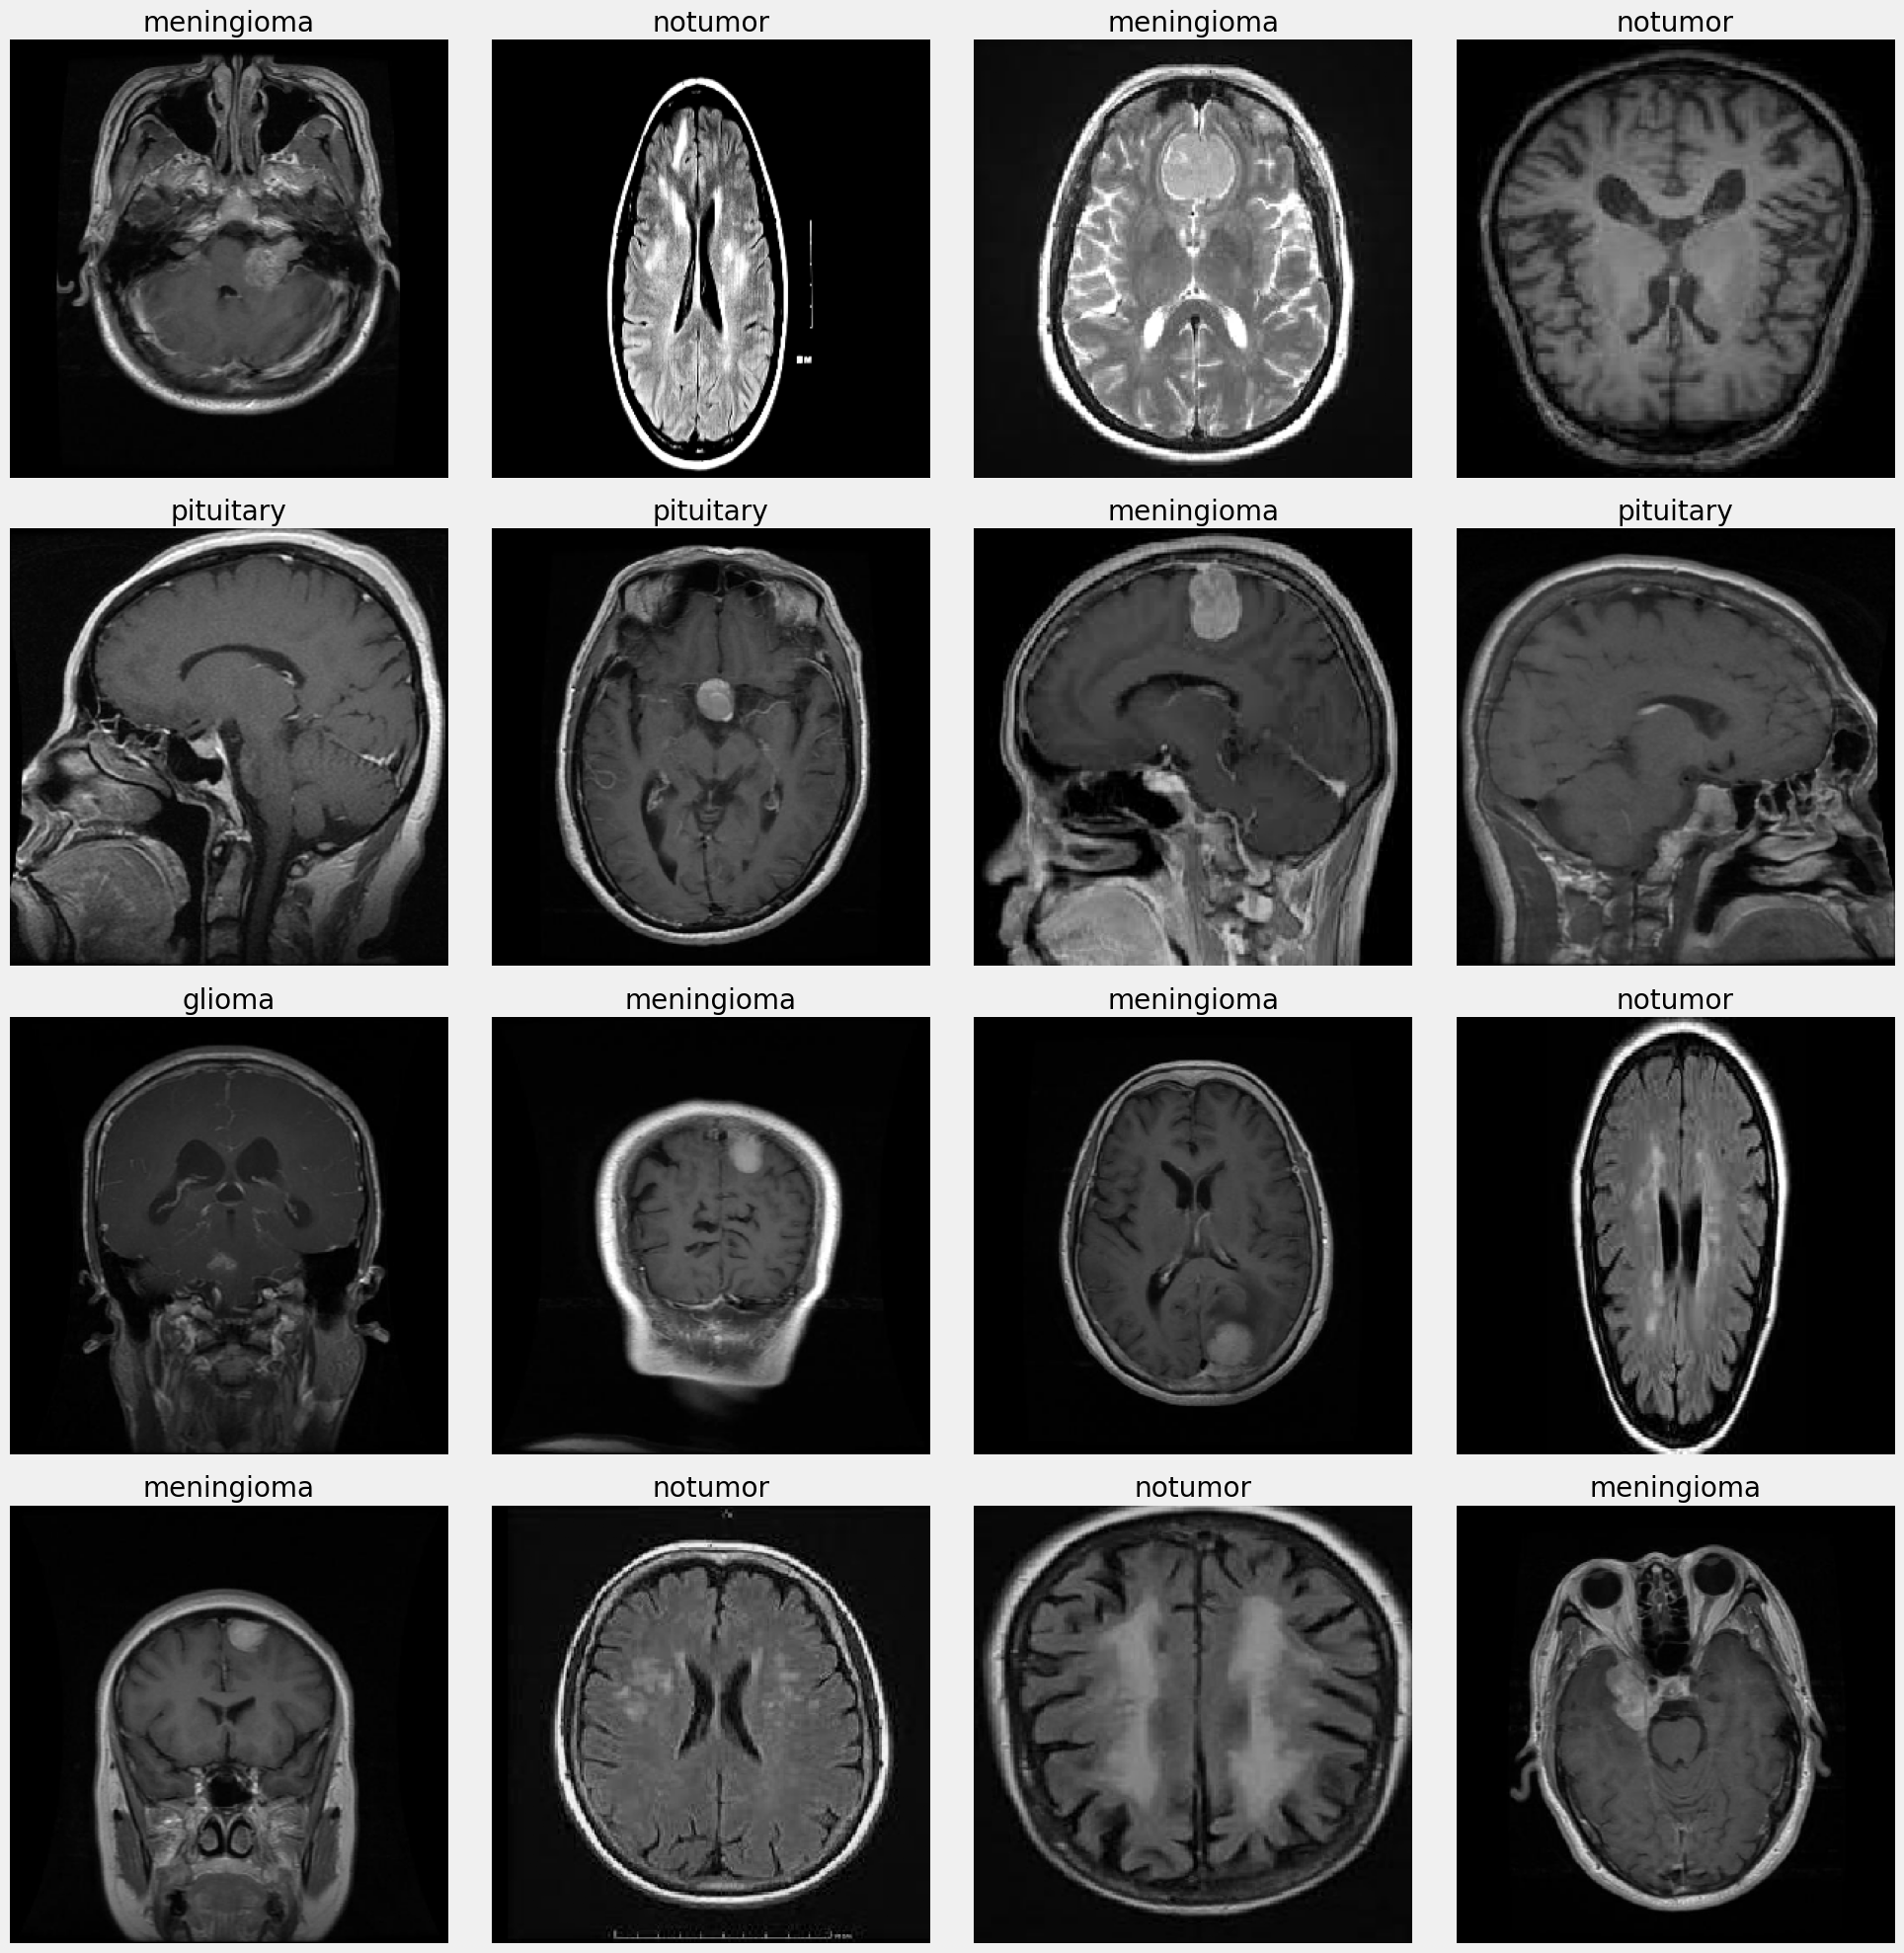

In [ ]:
plt.figure(figsize=(20,20))
for i in range(16):
  plt.subplot(4,4,i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  #Get the class index
  class_index = np.argmax(label)

  #Get class names / indices
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the corresponding class name
  class_name = class_names[index_position]
  plt.title(class_name)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#xception Model model works by breaking down the image into smaller easier to understand parts and then looks at those parts one by one
#Trained on Imagenet a popular dataset in the computer vision community. Sparked the deeplearning revolution
#Learned to recognize patterns and features that distinguish different objects (stripes on a tiger, circular shape of car tire)
#The training process involves a lost of trial and error In the beginning, the model might make mistakes but after each mistake
# it adjusts a little bit to improve its accuracy, this is done by using a process called backpropagation and optimization techniques
#like stochastic gradient descent

In [ ]:
img_shape = (299,299,3)#3 for color channels in RGB
base_model = tf.keras.applications.Xception(input_shape=img_shape, include_top=False, weights='imagenet',pooling='max')

model = Sequential([base_model,Flatten(),Dropout(rate=0.3),Dense(128,activation='relu'),Dropout(rate=0.25),Dense(4,activation='softmax')])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

Low learning rate means the model takes smaller steps went update weights(learn slowly but accurrately)

Larger learning rate means faster learning but less accurate results, the key is to find an efficient solution where the model runs as fast as possible while being as accurate as possible

In [ ]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7846 - loss: 0.7017 - precision_13: 0.8569 - recall_13: 0.6890 - val_accuracy: 0.9145 - val_loss: 0.2288 - val_precision_13: 0.9172 - val_recall_13: 0.9130
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 808ms/step - accuracy: 0.9801 - loss: 0.0615 - precision_13: 0.9819 - recall_13: 0.9753 - val_accuracy: 0.9725 - val_loss: 0.0648 - val_precision_13: 0.9755 - val_recall_13: 0.9710
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 204s 818ms/step - accuracy: 0.9925 - loss: 0.0275 - precision_13: 0.9926 - recall_13: 0.9924 - val_accuracy: 0.9863 - val_loss: 0.0404 - val_precision_13: 0.9878 - val_recall_13: 0.9863
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 146s 810ms/step - accuracy: 0.9969 - loss: 0.0096 - precision_13: 0.9972 - recall_13: 0.9969 - val_accuracy: 0.9649 - val_loss: 0.0936 - val_precision_13: 0.9649 - val_recall_13: 0.9649
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 816ms/step - accuracy: 0.9979 - loss: 0.0079 - precision_13: 0.9979 -

In [ ]:
print(hist.history.keys())

dict_keys(['accuracy', 'loss', 'precision_13', 'recall_13', 'val_accuracy', 'val_loss', 'val_precision_13', 'val_recall_13'])


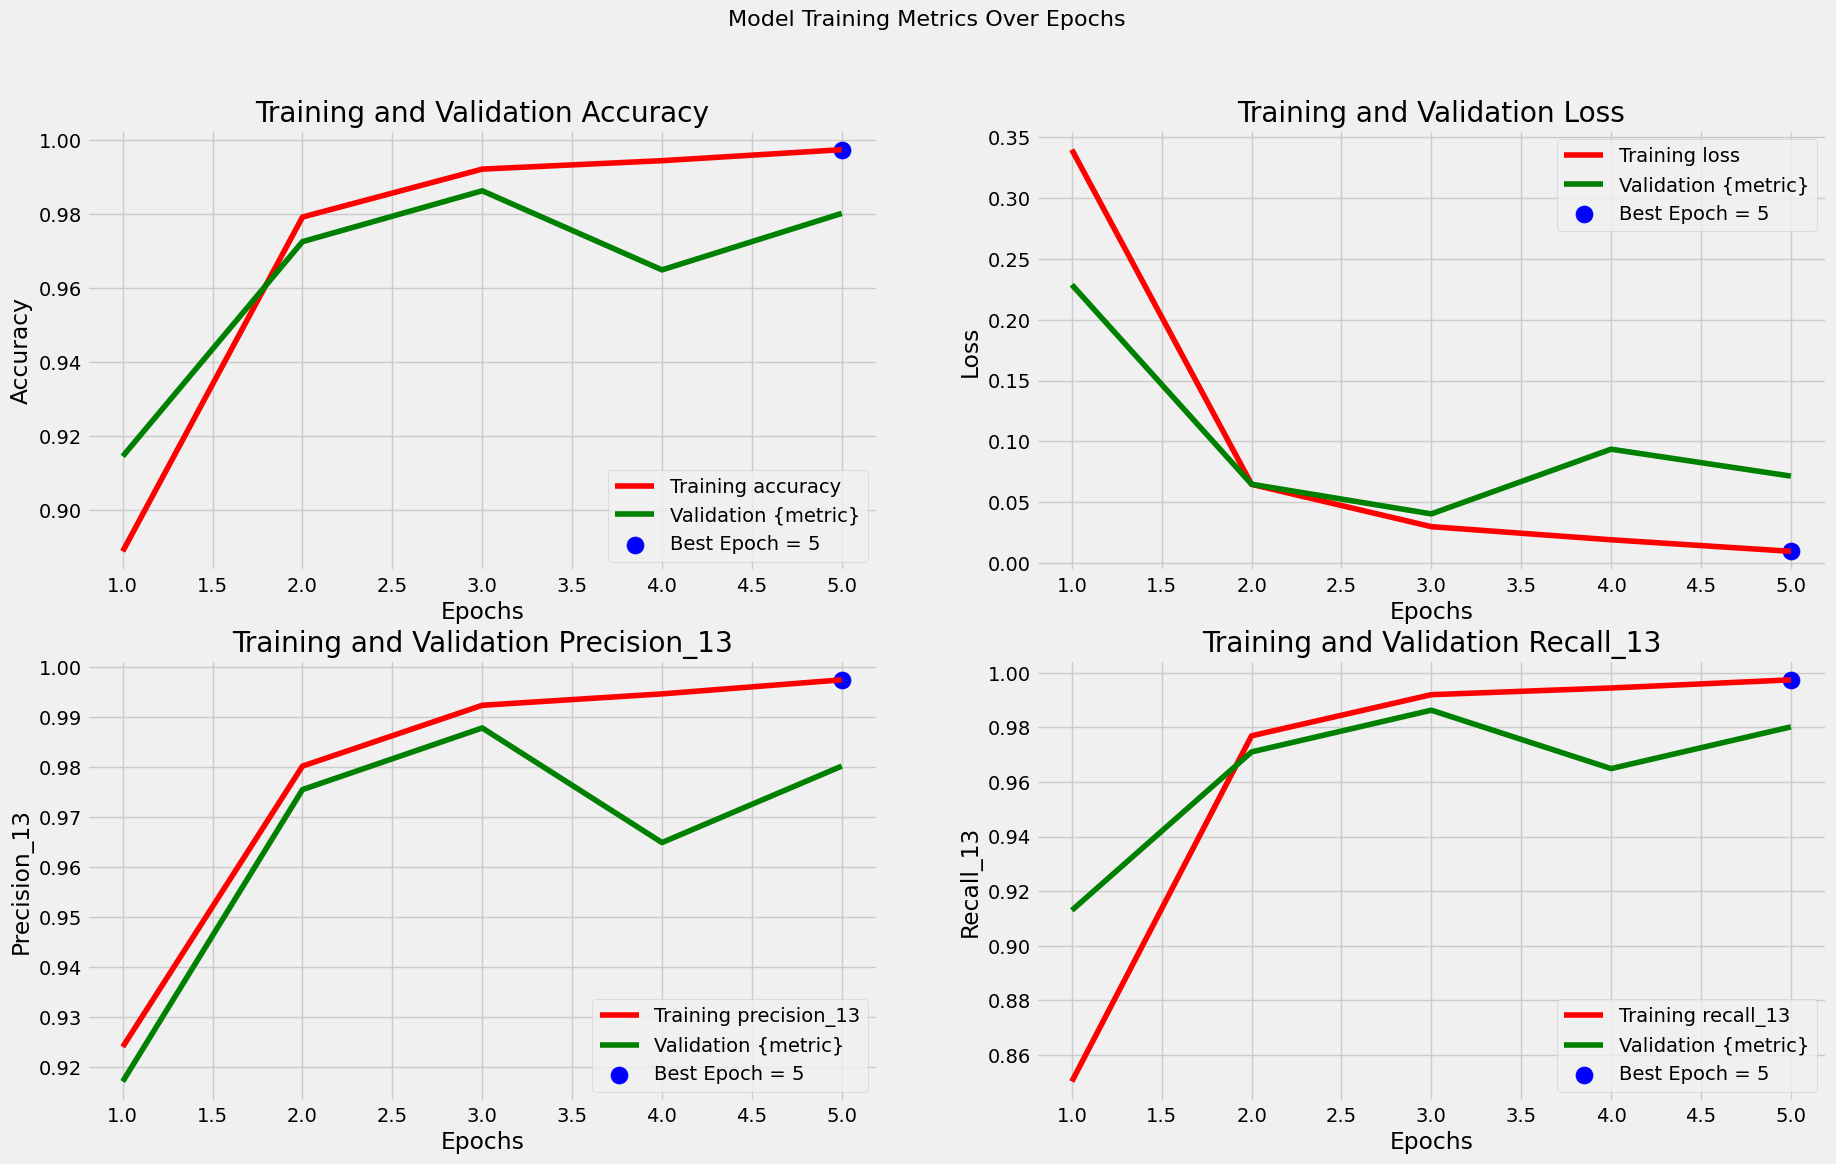

In [ ]:
metrics = ['accuracy', 'loss', 'precision_13', 'recall_13']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(tr_metrics[m])
  else:
    idx = np.argmax(tr_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = tr_metrics[m][idx]

plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) + 1 )

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g',label='Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best Epoch = {best_epochs[metric]}')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_score = model.evaluate(tr_gen, verbose = 1)
valid_score = model.evaluate(valid_gen, verbose = 1)
test_score = model.evaluate(ts_gen, verbose = 1)

print(f'Training Accuracy: {train_score[1]*100:.2f}%')
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.9970 - loss: 0.0126 - precision_13: 0.9970 - recall_13: 0.9970
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.9847 - loss: 0.0747 - precision_13: 0.9847 - recall_13: 0.9847
 1/41 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 1.0000 - loss: 4.5573e-04 - precision_13: 1.0000 - recall_13: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9914 - loss: 0.0324 - precision_13: 0.9914 - recall_13: 0.9905
Training Accuracy: 99.79%
Train Loss: 0.0086


Validation Accuracy: 98.32%
Validation Loss: 0.0688


Test Accuracy: 99.24%
Test Loss: 0.0268


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step


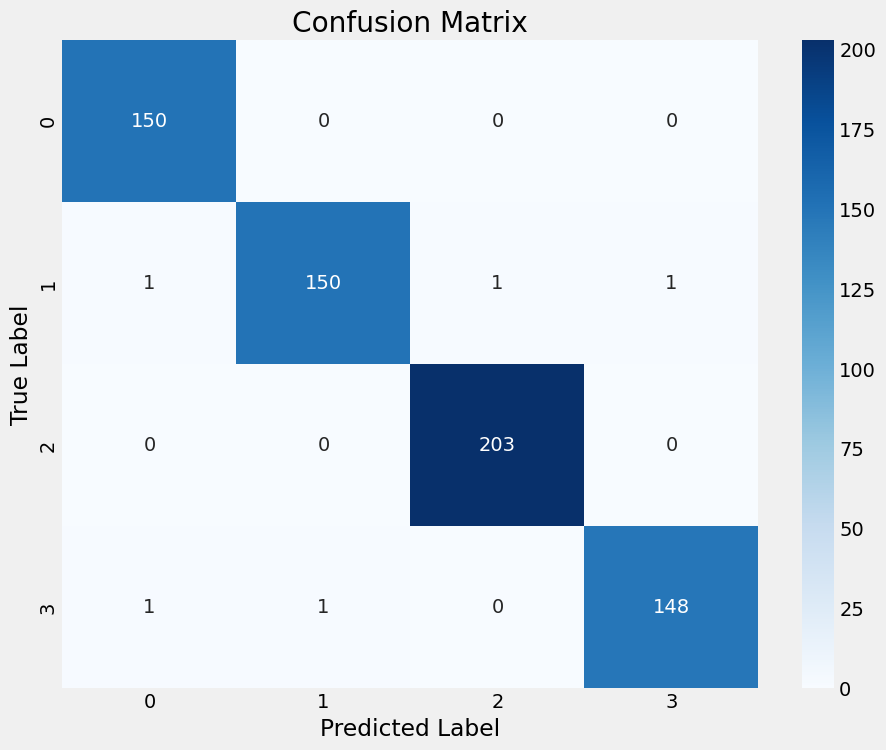

In [ ]:
#confusion matrix is a powerful visualization tool that shows where the model is strong in weak in predictions.
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from PIL import Image

def predict(img_path: str) -> None:
  #Get class labels
  labels = list(class_dict.keys())

  #Create figure
  plt.figure(figsize=(6,8))

  #Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.array(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  #Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  #Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  #Plot image
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  #Plot prediction probabilities
  plt.subplot(2,1,2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel('Probability',fontsize=15)
  plt.title('Class Probabilities')

  # Add probabilities labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


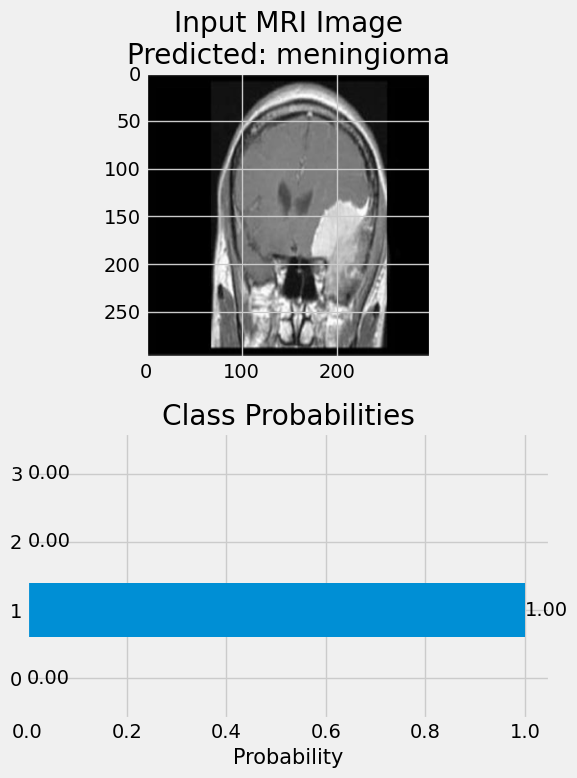


Predicted tumor type: meningioma


In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


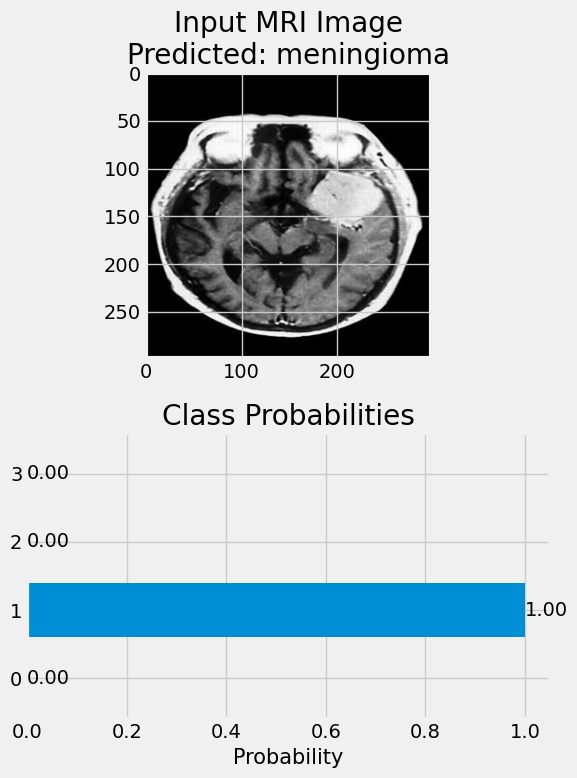


Predicted tumor type: meningioma


In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0005.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


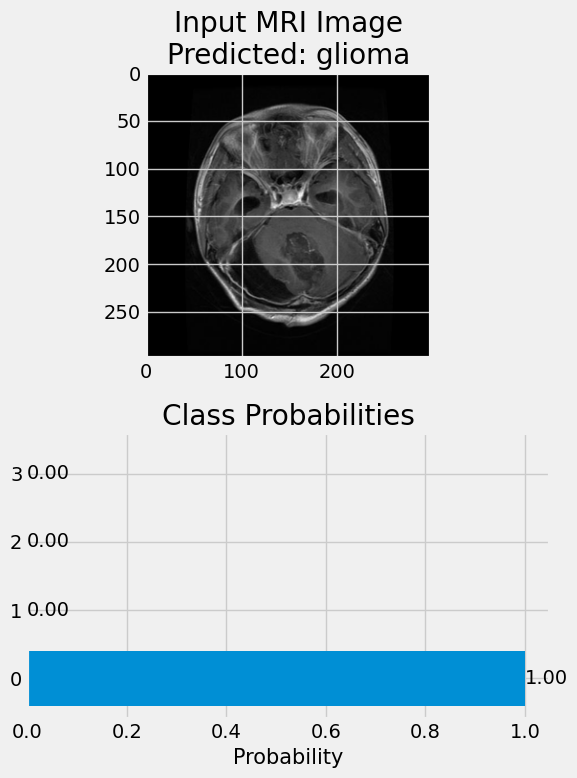


Predicted tumor type: glioma


In [ ]:
predict("/content/Testing/glioma/Te-glTr_0000.jpg")

In [ ]:
model.save_weights("xception_model.weights.h5")

#CNN Model - Convolutional Neural Network
 - Smaller model then Xception and cheaper to deploy in a real world setting
 - Much more flexible in deployment, can run on more GPUs, only needs 4-8GB
 - Low, suitable real time apps
 - cost effective for single or batch infer

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [ ]:
batch_size = 32 # 2^5+  are all valid batch sizes
img_size = (224, 224)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range = (0.8,1.2))
ts_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
tr_gen = image_generator.flow_from_dataframe(
    dataframe=tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(
    dataframe=ts_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=32,
    target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
#Create a Sequential CNN Model

cnn_model = Sequential()

#Convolutional Layers
cnn_model.add(Conv2D(512, (3,3), activation='relu', input_shape=(224,224,3), padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(BatchNormalization())

#Flatten the output for fully connected layers
cnn_model.add(Flatten())

#Fully Connected Layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.4))

cnn_model.add(Dense(4, activation='softmax')) # Output layer with 4 neurons for the 4 classes

#Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy',Precision(),Recall()])

#Display the model summary
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,876 (18.22 MB)

 Trainable params: 4,775,748 (18.22 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history = cnn_model.fit(tr_gen, epochs=10, validation_data=valid_gen)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 211s 908ms/step - accuracy: 0.5590 - loss: 2.5704 - precision: 0.6859 - recall: 0.3814 - val_accuracy: 0.7542 - val_loss: 1.0673 - val_precision: 0.8000 - val_recall: 0.6595
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 164s 617ms/step - accuracy: 0.8105 - loss: 0.8430 - precision: 0.8360 - recall: 0.7732 - val_accuracy: 0.7893 - val_loss: 0.7329 - val_precision: 0.8035 - val_recall: 0.7679
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 617ms/step - accuracy: 0.8578 - loss: 0.6008 - precision: 0.8712 - recall: 0.8370 - val_accuracy: 0.8305 - val_loss: 0.5764 - val_precision: 0.8532 - val_recall: 0.8076
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 613ms/step - accuracy: 0.8742 - loss: 0.5004 - precision: 0.8860 - recall: 0.8621 - val_accuracy: 0.8809 - val_loss: 0.4830 - val_precision: 0.8940 - val_recall: 0.8626
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 612ms/step - accuracy: 0.8957 - loss: 0.4242 - precision: 0.9017 - recall: 0.8877 - val_accuracy: 0.8901 - val

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


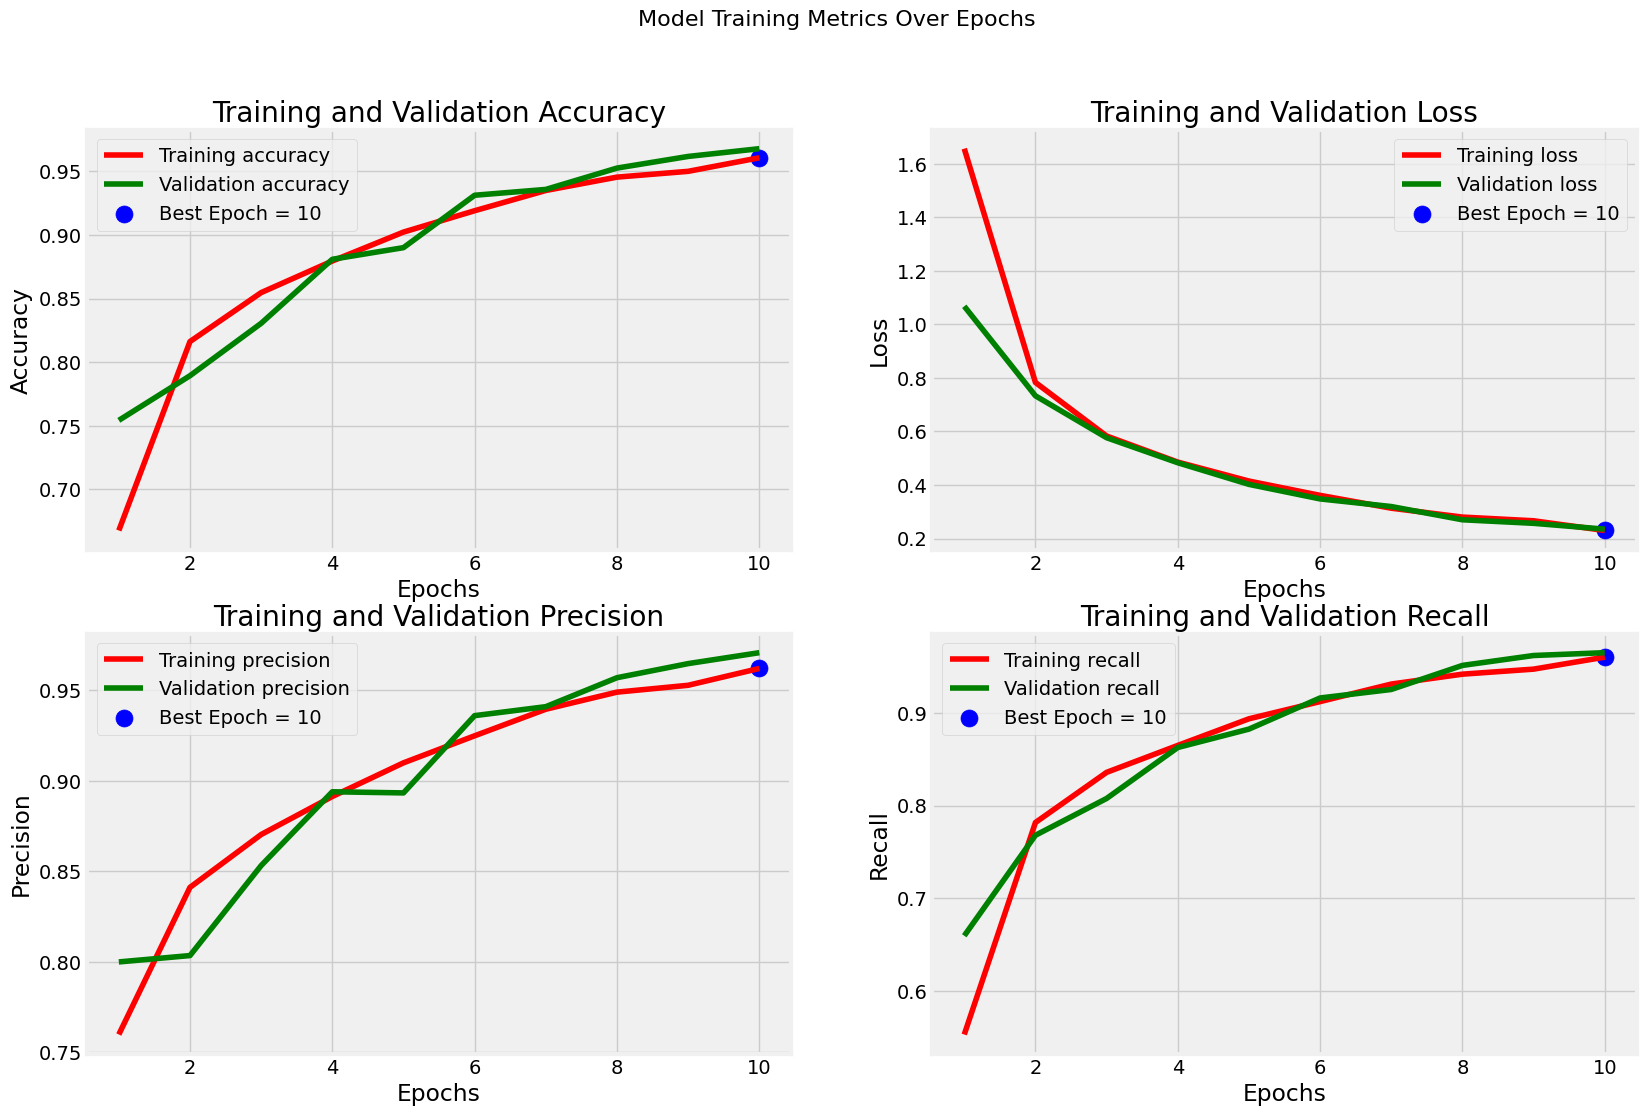

In [ ]:
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(tr_metrics[m])
  else:
    idx = np.argmax(tr_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = tr_metrics[m][idx]

plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) + 1 )

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g',label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best Epoch = {best_epochs[metric]}')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_score = cnn_model.evaluate(tr_gen, verbose = 1)
valid_score = cnn_model.evaluate(valid_gen, verbose = 1)
test_score = cnn_model.evaluate(ts_gen, verbose = 1)

print(f'Training Accuracy: {train_score[1]*100:.2f}%')
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9912 - loss: 0.1669 - precision: 0.9916 - recall: 0.9897
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9716 - loss: 0.2160 - precision: 0.9775 - recall: 0.9716
 1/21 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9688 - loss: 0.2643 - precision: 0.9688 - recall: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9309 - loss: 0.3411 - precision: 0.9315 - recall: 0.9268
Training Accuracy: 98.79%
Train Loss: 0.1712


Validation Accuracy: 96.79%
Validation Loss: 0.2282


Test Accuracy: 94.36%
Test Loss: 0.3009


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


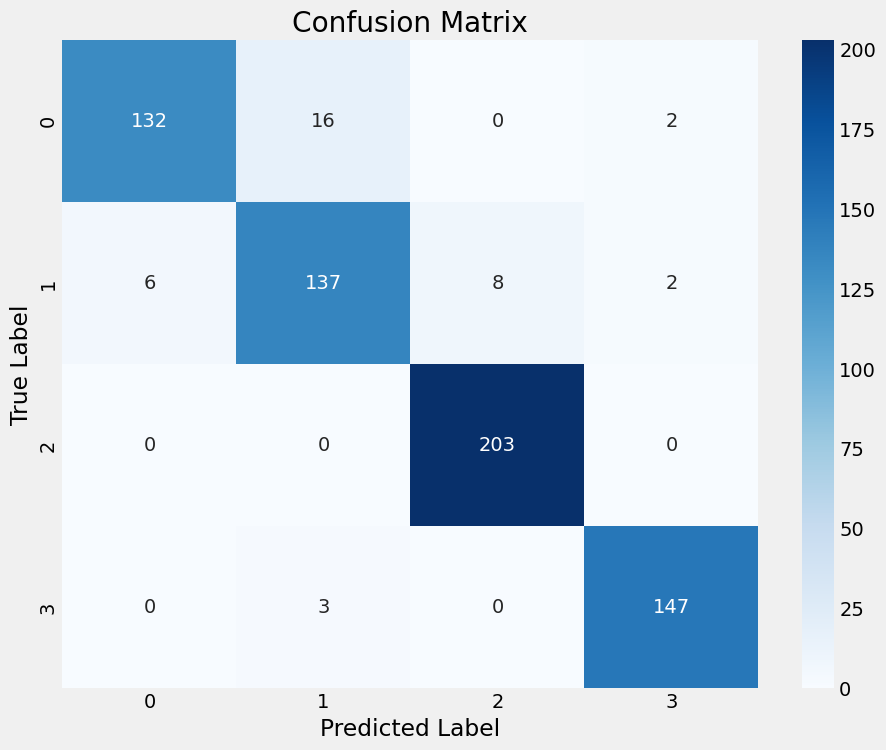

In [ ]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       150
           1       0.88      0.90      0.89       153
           2       0.96      1.00      0.98       203
           3       0.97      0.98      0.98       150

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656



In [ ]:
cnn_model.save("cnn_model.h5")

#Custom CNN Model
Some adjustments are made based on the results in order to the original model to help improve the accuracy.


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomRotation, RandomTranslation

In [15]:
batch_size = 16 # batch size of 16 to try first, then possibly 32
img_size = (224, 224)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range = (0.8,1.2))
ts_gen = ImageDataGenerator(rescale=1/255)

In [16]:
tr_gen = image_generator.flow_from_dataframe(
    dataframe=tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size,)

valid_gen = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(
    dataframe=ts_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=32,
    target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [17]:
#Custom Sequential CNN Model

cnn_model = Sequential()

#Convolutional Layers
cnn_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.1))
#Flatten the output for fully connected layers
cnn_model.add(Flatten())

#Fully Connected Layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.4))

cnn_model.add(Dense(4, activation='softmax')) # Output layer with 4 neurons for the 4 classes

#Compile the model
optimizer = Adamax(learning_rate = 0.001)
for layer in cnn_model.layers:
    if isinstance(layer, Dense):
        layer.trainable = True
        optimizer.learning_rate.assign(0.0005)
    elif isinstance(layer, Conv2D):
        layer.trainable = True
        optimizer.learning_rate.assign(0.001)
cnn_model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy',Precision(),Recall()])

#Display the model summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuil

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_2 = cnn_model.fit(tr_gen, epochs=15, validation_data=valid_gen, callbacks=[early_stopping])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 180s 420ms/step - accuracy: 0.4382 - loss: 2.4309 - precision: 0.7215 - recall: 0.2301 - val_accuracy: 0.6550 - val_loss: 1.8897 - val_precision: 0.9231 - val_recall: 0.1282
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 316ms/step - accuracy: 0.7742 - loss: 1.3510 - precision: 0.8098 - recall: 0.7286 - val_accuracy: 0.8015 - val_loss: 1.1428 - val_precision: 0.8223 - val_recall: 0.7557
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 144s 323ms/step - accuracy: 0.8439 - loss: 1.0388 - precision: 0.8599 - recall: 0.8202 - val_accuracy: 0.8382 - val_loss: 0.9760 - val_precision: 0.8565 - val_recall: 0.8290
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 319ms/step - accuracy: 0.8913 - loss: 0.8130 - precision: 0.9017 - recall: 0.8801 - val_accuracy: 0.8595 - val_loss: 0.7820 - val_precision: 0.8690 - val_recall: 0.8504
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 113s 315ms/step - accuracy: 0.9282 - loss: 0.6461 - precision: 0.9335 - recall: 0.9212 - val_accuracy: 0.8901 - val

In [19]:
print(history_2.history.keys())

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


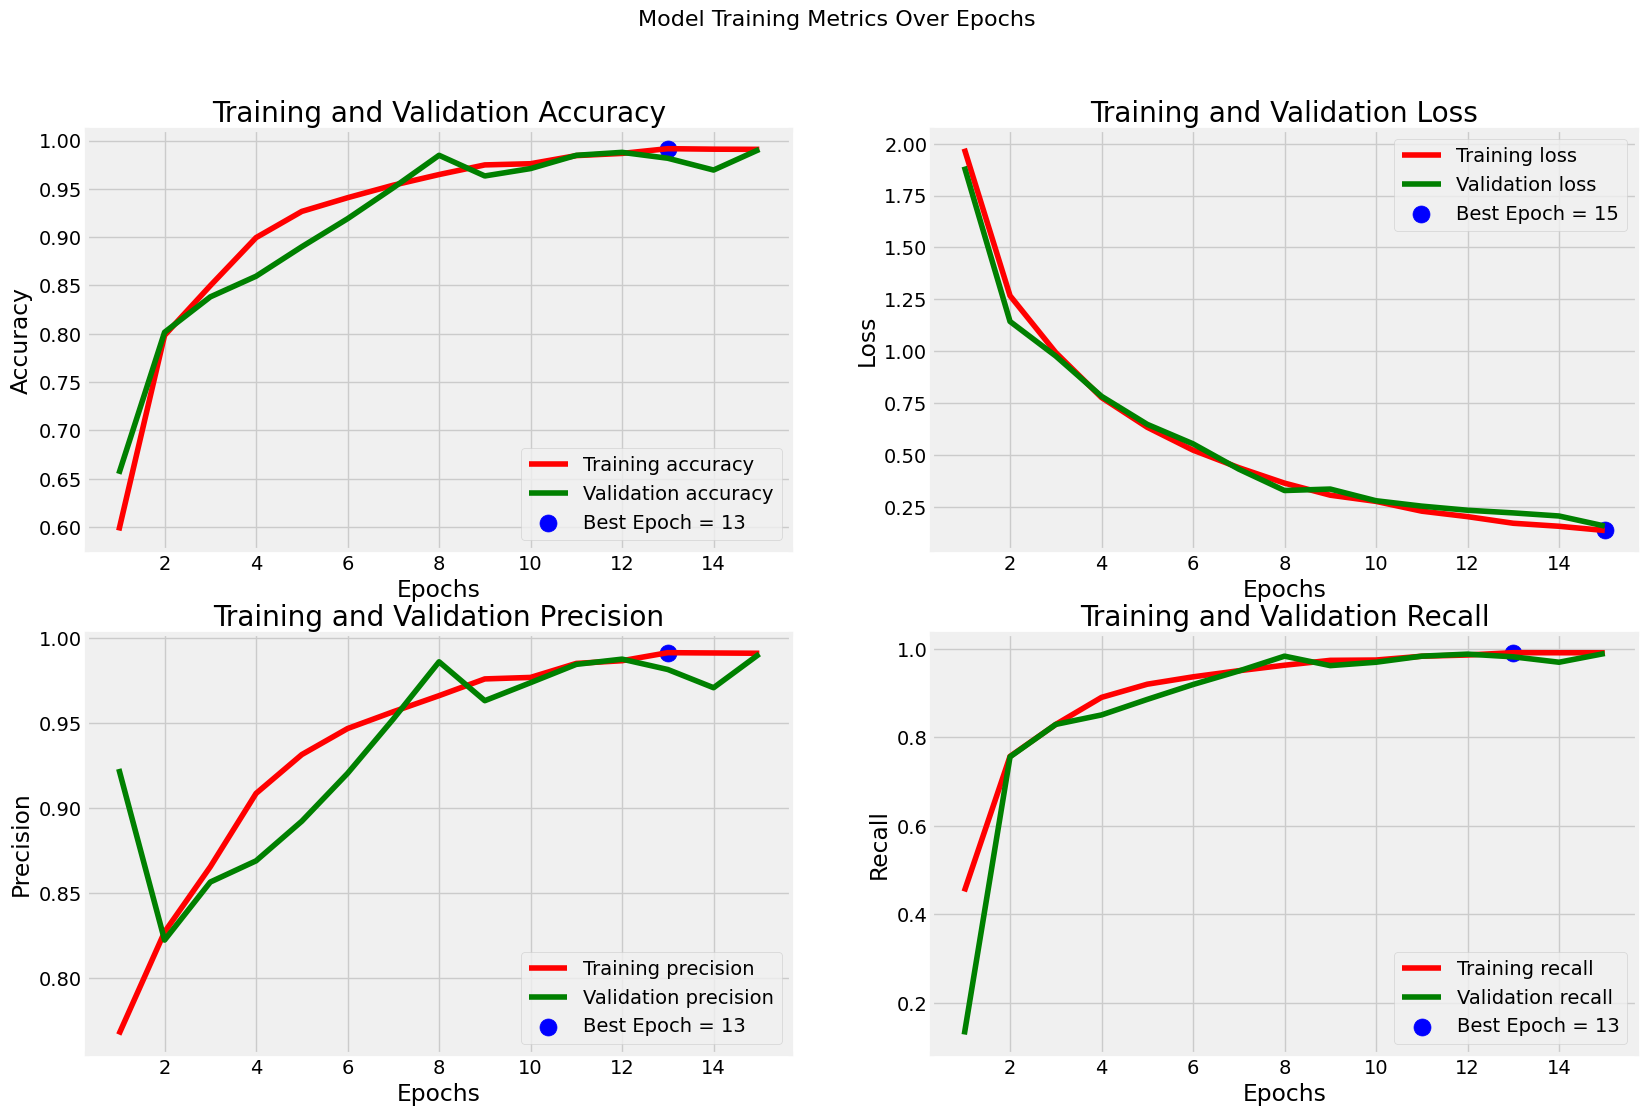

In [20]:
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: history_2.history[m] for m in metrics}
val_metrics = {m: history_2.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(tr_metrics[m])
  else:
    idx = np.argmax(tr_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = tr_metrics[m][idx]

plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) + 1 )

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g',label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best Epoch = {best_epochs[metric]}')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step


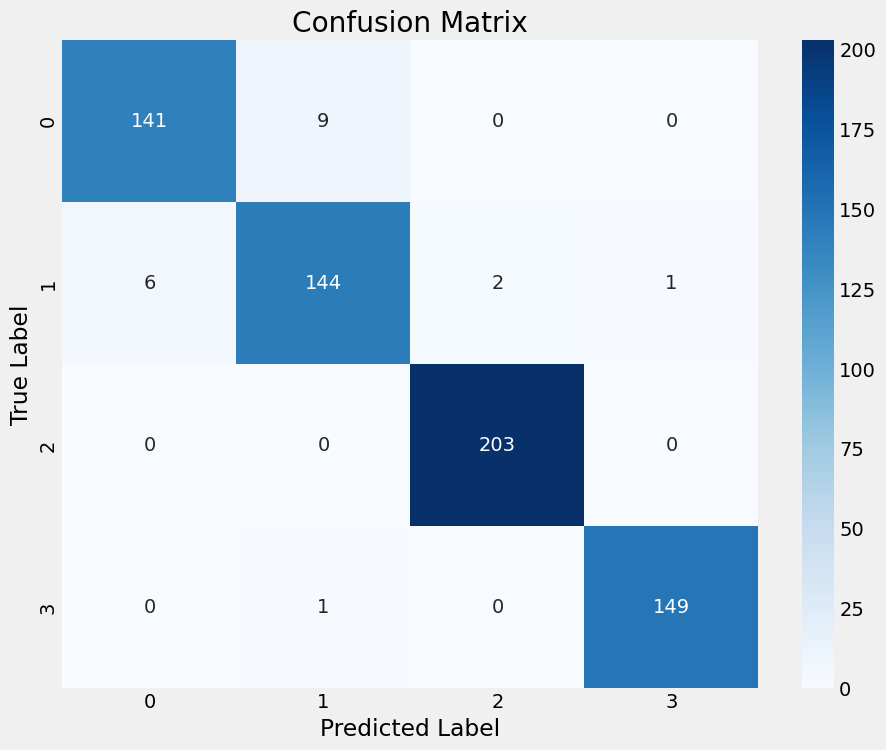

In [21]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       150
           1       0.94      0.94      0.94       153
           2       0.99      1.00      1.00       203
           3       0.99      0.99      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



In [23]:
cnn_model.save("custom_cnn_model.h5")

#Transfer Learning With ResNet

In [27]:
batch_size = 16 # 2^5+  are all valid batch sizes
img_size = (224, 224)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range = (0.8,1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [28]:
tr_gen = image_generator.flow_from_dataframe(
    dataframe=tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size,
)

valid_gen = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size,
    )

ts_gen = ts_gen.flow_from_dataframe(
    dataframe=ts_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=32,
    target_size=img_size,shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [14]:
from keras.layers import Activation
from tensorflow.keras.applications import DenseNet121

In [29]:
densenet_model = DenseNet121(weights='imagenet',
                             include_top=False,
                             input_shape=(224, 224, 3))

densenet_model.trainable = False

x = GlobalAveragePooling2D()(densenet_model.output)
x = Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.35)(x)
output = Dense(4, activation='softmax')(x)


model = Model(inputs=densenet_model.input, outputs=output)

for layer in densenet_model.layers[-10:]:
    layer.trainable = True

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.96
)
optimizer=Adamax(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy', Precision(), Recall()])

# Add callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [30]:
# Train the model
history = model.fit(tr_gen, epochs=10, validation_data=valid_gen, callbacks=[early_stopping])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 135ms/step - accuracy: 0.7844 - loss: 2.1200 - precision_2: 0.8343 - recall_2: 0.7121 - val_accuracy: 0.9282 - val_loss: 1.3218 - val_precision_2: 0.9514 - val_recall_2: 0.8962
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.9127 - loss: 1.2974 - precision_2: 0.9318 - recall_2: 0.8828 - val_accuracy: 0.9557 - val_loss: 1.0417 - val_precision_2: 0.9668 - val_recall_2: 0.9328
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9601 - loss: 1.0130 - precision_2: 0.9724 - recall_2: 0.9395 - val_accuracy: 0.9756 - val_loss: 0.8452 - val_precision_2: 0.9814 - val_recall_2: 0.9649
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9732 - loss: 0.8371 - precision_2: 0.9800 - recall_2: 0.9605 - val_accuracy: 0.9847 - val_loss: 0.7166 - val_precision_2: 0.9907 - val_recall_2: 0.9725
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.9815 - loss: 0.7244 - precision_2: 0.9876 - recall_2: 0.9688 -

In [31]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])


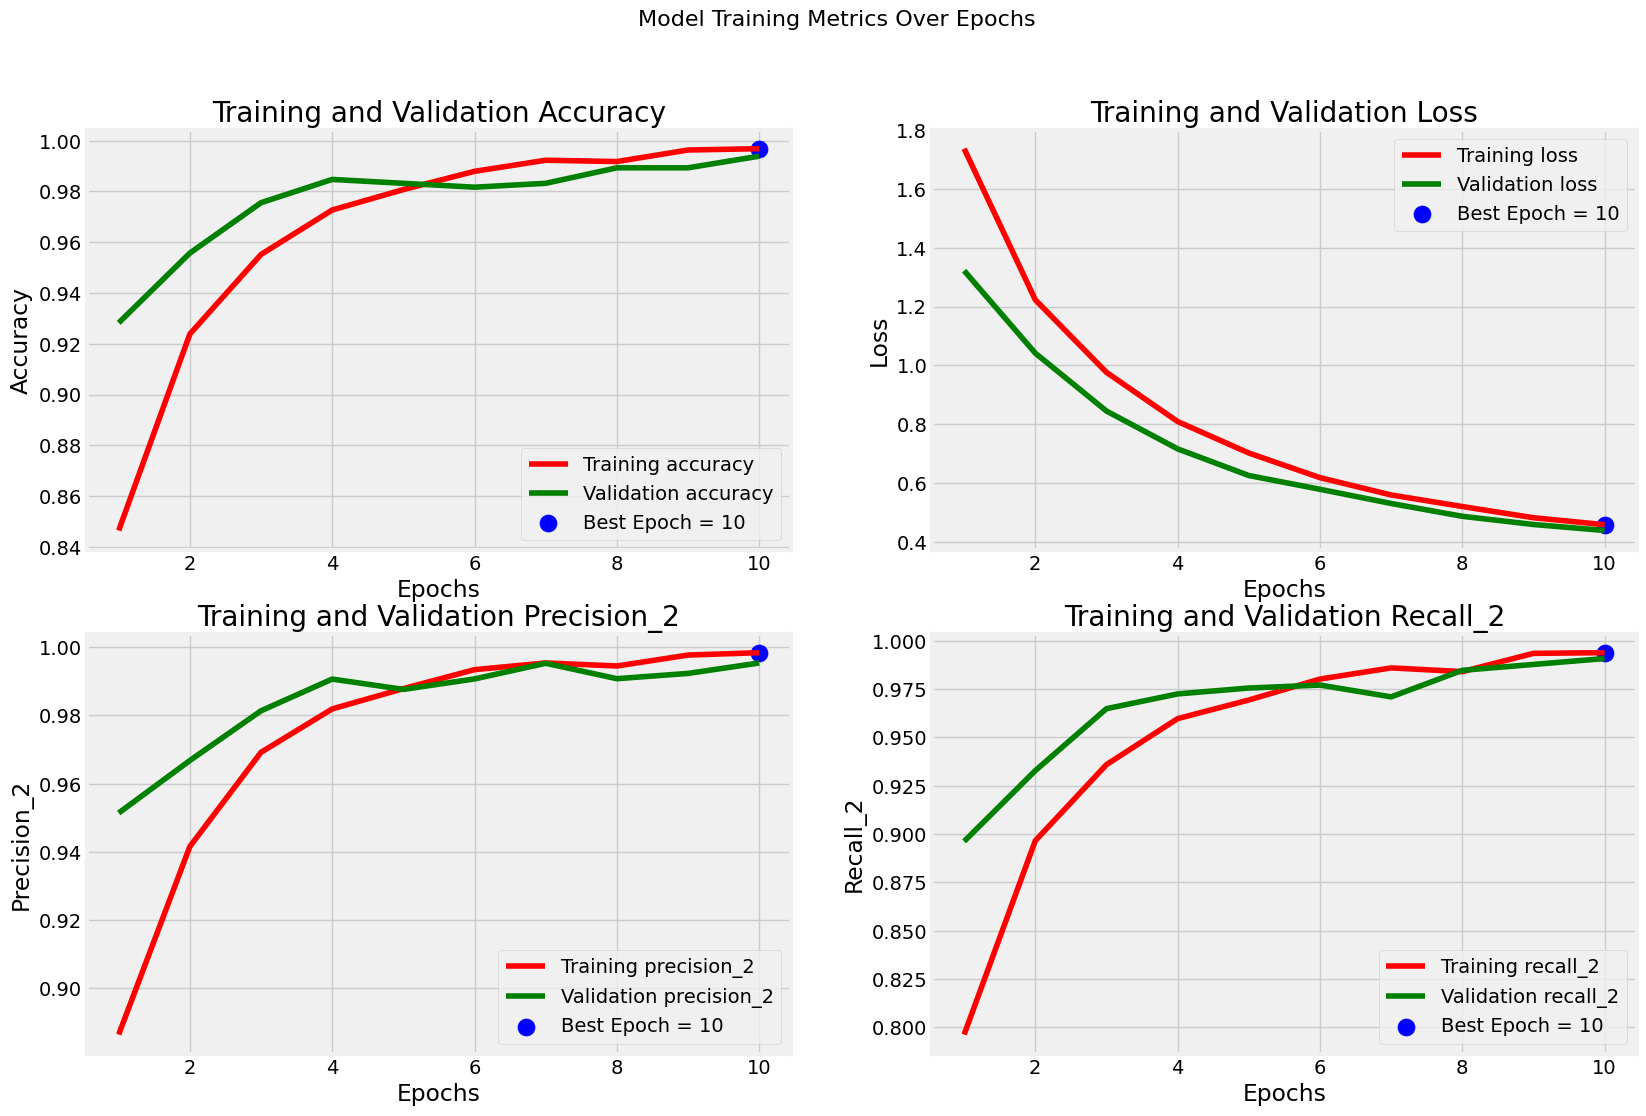

In [32]:
metrics = ['accuracy', 'loss', 'precision_2', 'recall_2']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(tr_metrics[m])
  else:
    idx = np.argmax(tr_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = tr_metrics[m][idx]

plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2,2,i)
  epochs = range(1, len(tr_metrics[metric]) + 1 )

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g',label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best Epoch = {best_epochs[metric]}')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [33]:
from PIL import Image

def predict(img_path: str) -> None:
  #Get class labels
  labels = list(class_dict.keys())

  #Create figure
  plt.figure(figsize=(6,8))

  #Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.array(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  #Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  #Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  #Plot image
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  #Plot prediction probabilities
  plt.subplot(2,1,2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel('Probability',fontsize=15)
  plt.title('Class Probabilities')

  # Add probabilities labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


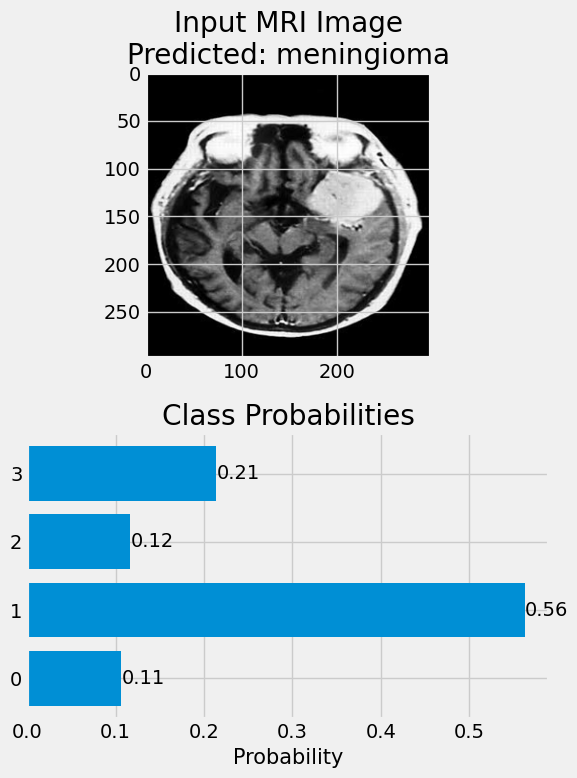


Predicted tumor type: meningioma


In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0005.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


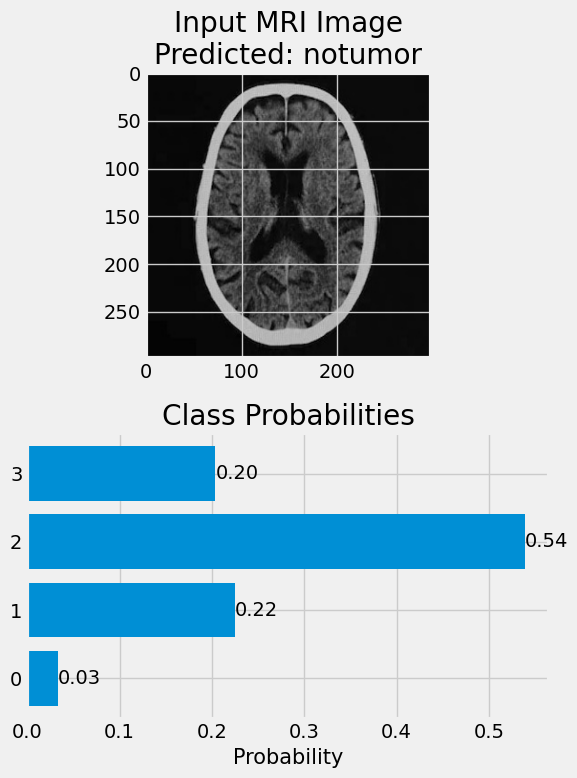


Predicted tumor type: notumor


In [ ]:
predict("/content/Testing/notumor/Te-noTr_0005.jpg")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 463ms/step


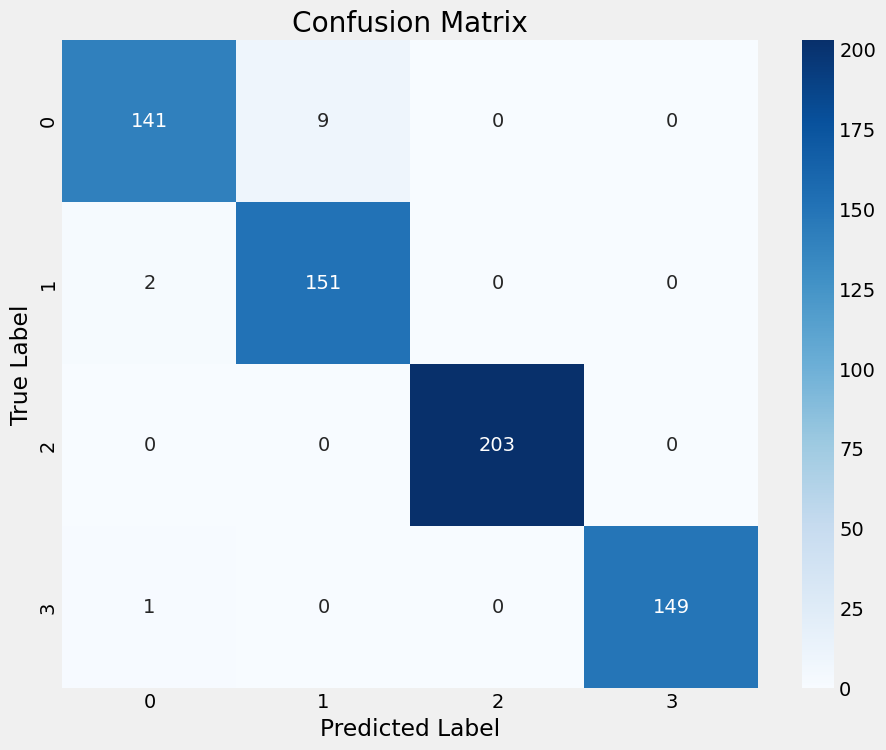

In [34]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
model.save('/content/densenet_model.h5')

# Part 2: Streamlit Web App


In [15]:
!pip install streamlit pyngrok python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [36]:
from threading import Thread #We need the server to run in a separate thread
from pyngrok import ngrok #Allows us to create secure tunnels to localhost
from google.colab import userdata

In [37]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [38]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [85]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import PIL.Image
import os
import google.generativeai as genai
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key=os.getenv('GOOGLE_API_KEY'))

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)
#Change neurologist or radiologist (different occupations), try improving prompt with chatgpt
def generate_report(img_path, model_prediction, confidence, model_name):
  img = PIL.Image.open(img_path)
  explanation =  generate_explanation(img_path, model_prediction, confidence, model_name, img)
  prompt = f"""You are an expert oncologist and have just finished providing an explanation of the results of the machine learning model based on the {model_prediction}.
  The deep learning model classifies that the patient either has a glioma, meningioma, pituitary, or no tumor.
    Based on the classification, give the patient a short paragraph containing some information about their tumor:
      - The rarity of the tumor based on medical evidence, include the percentage of brain tumors that is their specific tumor.
      - How severe the tumor is based on the saliency map in {img_path}
      - Provide a brief history on the tumor


      This is the formatting of the paragraphs in the report, where each label is its own paragraph:
        Overview: {explanation}, Title this paragraph: Overview
        Information About Your Tumor: The statistics, the severity of the tumor, and history of the tumor type. Keep this 5 sentences long. Title this paragraph: About Your Tumor
        The Next Steps: What the next steps are for the patient in doctors for treating the tumor. Make sure to make this it's own paragraph 6-8 sentences long. Title this paragraph:Treatment

      If there is no tumor, just have the Overview paragraph

      In the report:
        - Do not say here is a report or a draft of a report. Do not say that you are imitating a human, your manner of speech should be that of an expert oncologist.
        - Do not write anywhere else other than the content in the three paragraphs
        - Bold the titles of the paragraphs, make sure the title font is 2 levels larger than the text font
        - Make sure the paragraph starts the line under the title
        Let's think step by step about this. Verify step by step.
  """

  model = genai.GenerativeModel(model_name=model_name)
  response = model.generate_content([prompt, img])
  return response.text

def generate_explanation(img_path, model_prediction, confidence, model_name, img):
  prompt = f"""You are an expert oncologist. You are tasked with explaining a saliency map of a brain tumor MRI scan to a patient.
  The saliency map was generated by a deep learning model that was trained to classfiy brain tumors as either
  glioma, meningioma, pituitary, or no tumor.

  The saliency map highlights the regions of the image that the machine learning model is focusing on to make the prediction.

  The deep learning model predicted the scan of the patients' brain to be '{model_prediction}' with a confidence of {confidence * 100}%.

  In your response:
    - Explain what regions of the brain the model is focusing on, based on the saliency map. Refer to the regions highlighted in
    light cyan, those are the regions where the model is focusing on. Do not mention the color, saying referring to it as 'highlighted region' is fine.
    - Explain possible reasons why the model made the predition it did.
    - Don't mention anything like 'The saliency map highlights the regions the model is focusing on, which are in light cyan' in
    your explanation.
    - Keep the explanation to 4 sentences max.



    Let's think step by step about this. Verify step by step.
   """

  model = genai.GenerativeModel(model_name=model_name)
  response = model.generate_content([prompt, img])
  return response.text

def generate_saliency_map(model, img_array, class_index, img_size, img):
    with tf.GradientTape() as tape:
      img_tensor = tf.convert_to_tensor(img_array)
      tape.watch(img_tensor)
      predictions = model(img_tensor)
      target_class = predictions[:, class_index]

    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    #Resize gradients to match original image size
    gradients = cv2.resize(gradients, img_size)

    #Create a circular mask for the brain area
    center = (gradients.shape[0]//2, gradients.shape[1]//2)
    radius = min(center[0], center[1])-10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

    #Apply mask to gradients
    gradients = gradients * mask

    #Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
      brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max()-brain_gradients.min())
    gradients[mask] = brain_gradients

    #Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    #Apply more aggresive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    #Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.uint8(255*gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    #Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, img_size)

    #Superimpose the heatmap on the original image with increased opacity
    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, "wb") as f:
      f.write(uploaded_file.getbuffer())

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'

    #Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))

    return superimposed_img

st.title("Brain Tumor Classification")
st.write("Upload an image of a brain MRI scan to classify.")

def load_model_custom(model_path):
  img_shape = (299,299,3)#3 for color channels in RGB
  base_model = tf.keras.applications.Xception(input_shape=img_shape, include_top=False, weights='imagenet',pooling='max')

  model = Sequential([base_model,Flatten(),Dropout(rate=0.3),Dense(128,activation='relu'),Dropout(rate=0.25),Dense(4,activation='softmax')])

  model.build((None,) + img_shape)

  model.compile(Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

  model.load_weights(model_path)

  return model

def generate_infographics_and_report(uploaded_file, img_size, labels, ll_model):
  img = image.load_img(uploaded_file, target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /=255.0

  prediction = model.predict(img_array)

  #Get the class with the highest probability
  class_index = np.argmax(prediction[0])
  result = labels[class_index]

  st.write(f"Predicted Class: {result}")
  st.write(f"Predictions")

  saliency_map = generate_saliency_map(model, img_array, class_index, img_size, img)

  col1, col2 = st.columns(2)
  with col1:
    st.image(img, caption="Uploaded Image", use_container_width=True)
  with col2:
    st.image(saliency_map, caption="Saliency Map", use_container_width=True)

  st.write('## Classification Results')

  result_container = st.container()
  result_container  = st.container()
  result_container.markdown(
    f"""
    <div style="background-color:#000000; color: #ffffff; padding: 30px; border-radius: 15px;">
      <div style="display: flex; justify-content: space-between; align-items:center;">
        <div stype="flex: 1; text-align; center;">
          <h3 style="color: #ffffff; margin-bottom: 10px; font-size:20px;">Prediction</h3>
           <p style="font-size: 36px; font-weight: 800; color:#FF0000; margin: 0;">
             {result}
           </p>
        </div>
         <div style="width: 2px; height: 80px; background-color: #ffffff; margin:0 20px;"></div>
         <div stype="flex: 1; text-align; center;">
           <h3 style="color: #ffffff; margin-bottom: 10px; font-size:20px;">Confidence</h3>
           <p style="font-size: 36px; font-weight: 800; color:#2196F3; margin: 0;">
             {prediction[0][class_index]:.4%}
           </p>
         </div>
      </div>
    </div>
    """,
    unsafe_allow_html=True
  )

  #Prepare data for Plotly chart
  probabilities = prediction[0]
  sorted_indices = np.argsort(probabilities)[::-1]
  sorted_labels = [labels[i] for i in sorted_indices]
  sorted_probabilities = probabilities[sorted_indices]

  #Create a Plotly bar chart
  fig = go.Figure(go.Bar(
      x=sorted_probabilities,
      y=sorted_labels,
      orientation='h',
      marker_color=['red' if label == result else 'blue' for label in sorted_labels]
  ))

  #Customize the chart layout
  fig.update_layout(
      title='Probabilities for each class',
      xaxis_title='Probability',
      yaxis_title='Class',
      height = 400,
      width = 500,
      yaxis = dict(autorange="reversed")
  )

  #Add value labels to the bars
  for i, prob in enumerate(sorted_probabilities):
    fig.add_annotation(
        x=prob,
        y=i,
        text=f'{prob:.4f}',
        showarrow=False,
        xanchor='left',
        xshift=5
    )

  #Display the plotly
  st.plotly_chart(fig)

  saliency_map_path = f'saliency_maps/{uploaded_file.name}'
  report = generate_report(saliency_map_path, result, prediction[0][class_index],ll_model)
  st.write(report)


uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
labels = ["Glioma","Meningioma","No tumor", "Pituitary"]
if uploaded_file is not None:

  selected_model = st.selectbox(
    "Select Model",
    ["Select a model:", "Transfer Learning - Xception", "Transfer Learning - DenseNet", "Custom CNN"]
)

  if selected_model == "Select a model:":
    st.write("Please select a model from the dropdown.")
  else:
    st.write(f"You selected: {selected_model}")

  if selected_model == "Transfer Learning - Xception":
    model = load_model_custom('/content/xception_model.weights.h5')
    img_size = (299, 299)
  elif selected_model ==  "Transfer Learning - DenseNet":
    model = load_model('/content/densenet_model.h5')
    img_size = (224, 224)
  else:
    model = load_model('/content/custom_cnn_model (4).h5')
    img_size = (224, 224)

  selected_LLM=None
  if selected_model != "Select a model:":
    selected_LLM = st.selectbox(
    "Select an LLM to generate a report about the tumor.",
    ["Select an LLM: ", "Gemini 1.5 Flash", "Gemini 1.5 Pro", "LearnLM 1.5 Pro Exp"]
)

    chosen_LLM=" "
    if selected_LLM=="Gemini 1.5 Flash":
      chosen_LLM="gemini-1.5-flash"
    elif selected_LLM=="LearnLM 1.5 Pro Exp":
      chosen_LLM="learnlm-1.5-pro-experimental"
    elif selected_LLM=="Gemini 1.5 Pro":
      chosen_LLM="gemini-1.5-pro"

    if chosen_LLM != " ":
      generate_infographics_and_report(uploaded_file, img_size, labels, chosen_LLM)



Overwriting app.py


In [82]:
thread = Thread(target=run_streamlit)
thread.start()

In [83]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://c4cc-34-83-23-247.ngrok-free.app" -> "http://localhost:8501"


In [81]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url}->{tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

Closing tunnel: https://abbb-34-83-23-247.ngrok-free.app->http://localhost:8501


In [ ]:
from google.colab import drive
drive.mount('/content/drive')#Save work before resetting

Mounted at /content/drive
